In [ ]:
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split

# # Load data
# data = pd.read_csv('/content/preprocessed_data.csv')
# data['Timestamp'] = pd.to_datetime(data['Timestamp'])

# # Define input sequence length (number of past observations to consider)
# input_seq_length = 10  # Example: Use the past 10 observations

# # Create input sequences and target values
# X = []
# y = []

# for i in range(len(data) - input_seq_length):
#     X.append(data[['Throughput', 'LossRate', 'Latency', 'SendingRate']].iloc[i:i+input_seq_length].values)
#     y.append(data[['Throughput', 'LossRate', 'Latency', 'SendingRate']].iloc[i+input_seq_length].values)

# X = np.array(X)
# y = np.array(y)

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# # Now X_train, X_test are input sequences, and y_train, y_test are target values


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler


['/content/ client1 _bbr_full.csv',
           '/content/client1_cubic_full.csv',
           '/content/client1_pcc.csv',
           '/content/client2_bbr_switch_cubic.csv',
           '/content/client2_pcc.csv',
           '/content/client2_pcc_switch_bbr.csv']

# Load the dataset into a pandas DataFrame
# Assuming your data is stored in a CSV file named 'network_data.csv'
df = pd.read_csv('/content/preprocessed_data.csv')

# Extract relevant columns
features = ["Throughput", "LossRate", "Latency", "SendingRate"]
X = df[features]

# Normalize the data
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

# Add timestamps to the normalized feature vectors
timestamps = pd.to_datetime(df["Timestamp"])
state_representation = pd.concat([pd.DataFrame(timestamps), pd.DataFrame(X_normalized)], axis=1)
state_representation.columns = ["Timestamp"] + features
print(state_representation)


                        Timestamp  Throughput  LossRate   Latency  SendingRate
0   1970-01-01 00:00:01.717048758    0.760182  0.016432  0.005656     0.442732
1   1970-01-01 00:00:01.717048759    0.884752  0.001493  0.005097     0.462510
2   1970-01-01 00:00:01.717048760    0.689559  0.000856  0.005669     0.453094
3   1970-01-01 00:00:01.717048761    0.530437  0.000644  0.009459     0.540156
4   1970-01-01 00:00:01.717048762    0.338825  0.000546  0.008435     0.523768
..                            ...         ...       ...       ...          ...
629 1970-01-01 00:00:01.717054707    0.460341  0.000034  0.005437     0.809757
630 1970-01-01 00:00:01.717054708    0.475818  0.000033  0.005536     0.826026
631 1970-01-01 00:00:01.717054709    0.452155  0.000033  0.005054     0.797003
632 1970-01-01 00:00:01.717054710    0.477098  0.000032  0.005383     0.780425
633 1970-01-01 00:00:01.717054711    0.460341  0.000031  0.005021     0.832630

[634 rows x 5 columns]


In [1]:
import pandas as pd
import os

# List of filenames
csv_files = [
    '/content/client1_bbr_full.csv',
    '/content/client1_cubic_full.csv',
    '/content/client1_pcc.csv',
    '/content/client2_bbr_switch_cubic.csv',
    '/content/client2_pcc.csv',
    '/content/client2_pcc_switch_bbr.csv'
]

# Function to extract CCA from the filename
def get_cca_from_filename(filename, switch_time=40):
    if 'switch' in filename:
        if 'bbr_switch_cubic' in filename:
            return 'BBR', 'CUBIC', switch_time
        elif 'pcc_switch_bbr' in filename:
            return 'PCC', 'BBR', switch_time
    elif 'bbr' in filename:
        return 'BBR', None, None
    elif 'cubic' in filename:
        return 'CUBIC', None, None
    elif 'pcc' in filename:
        return 'PCC', None, None
    else:
        return 'UNKNOWN', None, None

# Initialize an empty list to hold DataFrames
dataframes = []

# Loop through the list of CSV files and read each one into a DataFrame
for file in csv_files:
    if os.path.exists(file):
        df = pd.read_csv(file)
        if 'Timestamp' not in df.columns:
            print(f"Warning: 'Timestamp' column not found in {file}. Skipping this file.")
            continue
        df['Timestamp'] = pd.to_datetime(df['Timestamp'])  # Ensure Timestamp is in datetime format
        df['time'] = (df['Timestamp'] - df['Timestamp'].min()).dt.total_seconds()  # Create a 'time' column in seconds
        cca1, cca2, switch_time = get_cca_from_filename(file)
        if cca2 is None:
            df['CCA'] = cca1
        else:
            df['CCA'] = [cca1 if t <= switch_time else cca2 for t in df['time']]
        dataframes.append(df)
    else:
        print(f"File not found: {file}")

# Concatenate all DataFrames into a single DataFrame if dataframes list is not empty
if dataframes:
    combined_data = pd.concat(dataframes, ignore_index=True)
    # Save the combined DataFrame to a CSV file
    combined_data.to_csv('/content/combined_data.csv', index=False)
    print("Combined data saved to '/content/combined_data.csv'")
else:
    print("No valid files were found. Please check the file paths and content.")


File not found: /content/client1_bbr_full.csv
Combined data saved to '/content/combined_data.csv'


In [2]:
# Check for missing values in the combined dataset
missing_values = combined_data.isnull().sum()
print("Missing values in each column:")
print(missing_values)


Missing values in each column:
Timestamp       0
Throughput      0
LossRate        0
Latency        13
SendingRate     0
time            0
CCA             0
dtype: int64


In [3]:
# Fill missing values for numerical columns with mean
for col in combined_data.select_dtypes(include=['float64', 'int64']).columns:
    combined_data[col].fillna(combined_data[col].mean(), inplace=True)

# Fill missing values for categorical columns with mode
for col in combined_data.select_dtypes(include=['object']).columns:
    combined_data[col].fillna(combined_data[col].mode()[0], inplace=True)

# Verify if all missing values are handled
missing_values_post = combined_data.isnull().sum()
print("Missing values after handling:")
print(missing_values_post)


Missing values after handling:
Timestamp      0
Throughput     0
LossRate       0
Latency        0
SendingRate    0
time           0
CCA            0
dtype: int64


In [4]:
from sklearn.preprocessing import StandardScaler

# Select numerical columns for standardization
numerical_cols = combined_data.select_dtypes(include=['float64', 'int64']).columns

# Standardize numerical columns
scaler = StandardScaler()
combined_data[numerical_cols] = scaler.fit_transform(combined_data[numerical_cols])

# Display the first few rows after standardization
print(combined_data.head())


            Timestamp  Throughput   LossRate       Latency  SendingRate  \
0 2024-05-30 07:31:40   -2.063979  16.292751  8.473640e-17    -3.328244   
1 2024-05-30 07:31:41   -0.170823   0.580359  8.473640e-17    -0.282757   
2 2024-05-30 07:31:42    0.504422  -0.011853  8.473640e-17    -0.916587   
3 2024-05-30 07:31:43    1.590342  -0.047357  8.473640e-17    -0.755940   
4 2024-05-30 07:31:44    1.758314  -0.060487  8.473640e-17    -0.867777   

       time    CCA  
0 -1.712318  CUBIC  
1 -1.680774  CUBIC  
2 -1.649230  CUBIC  
3 -1.617685  CUBIC  
4 -1.586141  CUBIC  


In [5]:
# Replace categorical values with numeric labels
combined_data['CCA'] = combined_data['CCA'].astype('category')
combined_data['CCA'] = combined_data['CCA'].cat.codes

# Impute missing values with the mean of each feature
combined_data.fillna(combined_data.mean(), inplace=True)

# Normalize features if needed (optional)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
combined_data[['Throughput', 'Latency', 'LossRate', 'SendingRate', 'CCA']] = scaler.fit_transform(combined_data[['Throughput', 'Latency', 'LossRate', 'SendingRate', 'CCA']])


In [6]:
# Save preprocessed data to a CSV file
combined_data.to_csv('preprocessed_data.csv', index=False)


In [7]:
# Split the data into training and testing sets
split_index = int(0.8 * len(combined_data))
train_data = combined_data.iloc[:split_index]
test_data = combined_data.iloc[split_index:]


In [8]:
import gym
from gym import spaces
import numpy as np

class CongestionControlEnv(gym.Env):
    def __init__(self, data, thresholds):
        super(CongestionControlEnv, self).__init__()
        self.data = data
        self.thresholds = thresholds
        self.observation_space = spaces.Box(low=0, high=1, shape=(4,), dtype=np.float32)  # Throughput, Latency, LossRate, SendingRate
        self.action_space = spaces.Discrete(2)  # Binary action: 0 for no switch, 1 for switch
        self.current_step = 0
        self.state = None  # Initialize state as None

    def reset(self):
        # Reset the environment
        self.current_step = 0
        self.state = self.data.iloc[self.current_step][['Throughput', 'Latency', 'LossRate', 'SendingRate']].values
        return self.state if self.state is not None else np.zeros(4)  # Return zeros if state is None

    def step(self, action):
        # Take an action (0: no switch, 1: switch)
        if action == 1:
            # Switch the congestion control algorithm
            pass  # Implement your logic here
        # Move to the next step
        self.current_step += 1
        done = self.current_step >= len(self.data)
        if not done:
            self.state = self.data.iloc[self.current_step][['Throughput', 'Latency', 'LossRate', 'SendingRate']].values
        else:
            self.state = None
        # Calculate reward
        reward = self._calculate_reward(action)
        return self.state, reward, done, {}

    def _calculate_reward(self, action):
        if self.state is None:  # Handle case where state is None
            return 0  # Return zero reward if state is None
        disparities = np.abs(self.state - self.data.iloc[self.current_step-1][['Throughput', 'Latency', 'LossRate', 'SendingRate']].values)
        reward = 0
        if np.any(disparities > self.thresholds):
            reward += 1  # High disparities reward
        else:
            reward -= 0.1  # Low disparities penalty
        if action == 1:
            reward -= 0.5  # Switching penalty
        return reward


In [9]:
import tensorflow as tf
from tensorflow.keras import layers
import random

class DQNAgent:
    def __init__(self, state_shape, action_space):
        self.state_shape = state_shape
        self.action_space = action_space
        self.model = self.build_model()
        self.replay_buffer = []
        self.gamma = 0.95  # Discount factor for future rewards
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995

    def build_model(self):
        model = tf.keras.Sequential([
            layers.Dense(64, activation='relu', input_shape=self.state_shape),
            layers.Dense(64, activation='relu'),
            layers.Dense(self.action_space, activation='linear')
        ])
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')
        return model

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_space)  # Explore: choose random action
        # Convert state to float32 tensor
        state_tensor = tf.convert_to_tensor(state, dtype=tf.float32)
        act_values = self.model.predict(state_tensor)[0]  # Exploit: choose best action based on current Q-values
        return np.argmax(act_values)

    def remember(self, state, action, reward, next_state, done):
        self.replay_buffer.append((state, action, reward, next_state, done))

    def train(self, batch_size):
        if len(self.replay_buffer) > batch_size:
            minibatch = random.sample(self.replay_buffer, batch_size)
            for state, action, reward, next_state, done in minibatch:
                target = reward
                if not done:
                    # Convert next_state to float32 tensor
                    next_state_tensor = tf.convert_to_tensor(next_state, dtype=tf.float32)
                    target = (reward + self.gamma *
                              np.amax(self.model.predict(next_state_tensor)[0]))
                # Convert state to float32 tensor
                state_tensor = tf.convert_to_tensor(state, dtype=tf.float32)
                target_f = self.model.predict(state_tensor)
                target_f[0][action] = target
                self.model.fit(state_tensor, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [ ]:
import numpy as np

# Parameters
EPISODES = 1000
BATCH_SIZE = 32

# Initialize environment and agent
env = CongestionControlEnv(data=combined_data, thresholds=[0.1, 0.1, 0.1, 0.1])
state_shape = env.observation_space.shape
action_space = env.action_space.n
agent = DQNAgent(state_shape, action_space)

# Training loop
for episode in range(EPISODES):
    state = env.reset()
    state = np.reshape(state, [1, state_shape[0]])
    total_reward = 0
    done = False
    while not done:
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        if next_state is not None:
            next_state = np.reshape(next_state, [1, state_shape[0]])
            total_reward += reward
            agent.remember(state, action, reward, next_state, done)
            state = next_state
        else:
            break
    agent.train(BATCH_SIZE)
    print(f"Episode: {episode + 1}, Total Reward: {total_reward}")




Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 35ms/step
Episode: 245, Total Reward: 28.899999999999807
1/1 [==============================] - 0s 27ms/step
Episode: 246, Total Reward: 28.899999999999878
1/1 [==============================] - 0s 26ms/step
Episode: 247, Total Reward: 18.899999999999977
1/1 [==============================] - 0s 47ms/step
Episode: 248, Total Reward: 25.90000000000005
1/1 [==============================] - 0s 28ms/step
Episode: 249, Total Reward: 27.39999999999987
1/1 [==============================] - 0s 24ms/step
Episode: 250, Total Reward: 24.900000000000006
1/1 [==============================] - 0s 29ms/step
Episode: 251, Total Reward: 32.89999999999978
1/1 [==============================] - 0s 32ms/step
Episode: 252, Total Reward: 26.39999999999979
1/1 [==============================] - 0s 28ms/step
Episode: 253, Total Reward: 25.399999999999878
1/1 [==============================] - 0s 26ms/step
Episode: 2

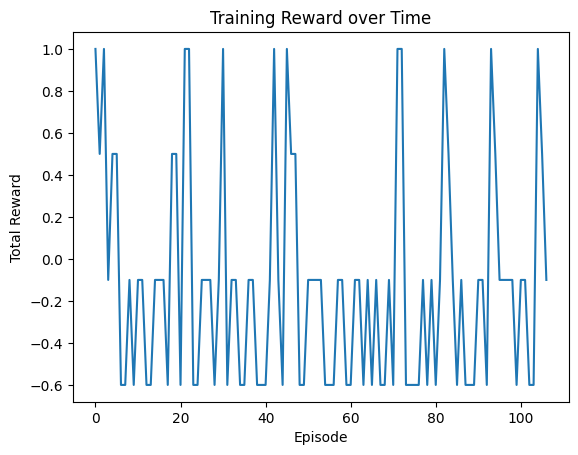

In [24]:
# Plot the rewards
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Training Reward over Time')
plt.savefig('training_rewards.png')
plt.show()



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


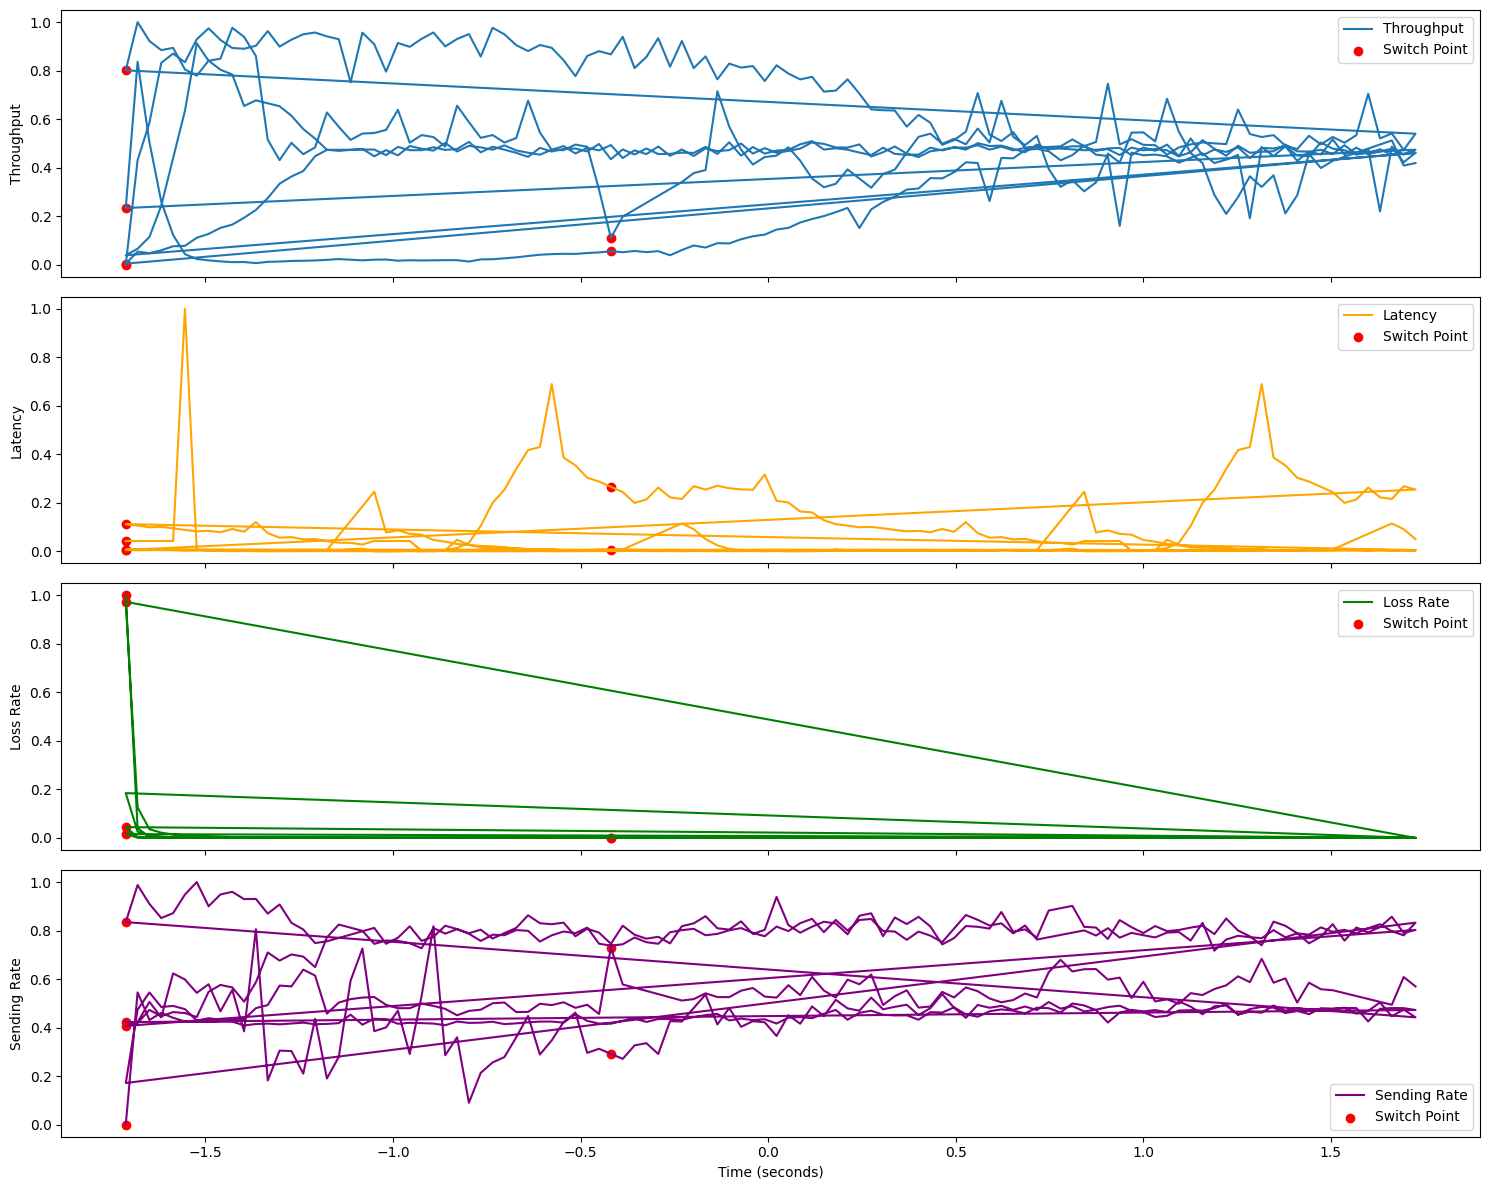

In [23]:
import matplotlib.pyplot as plt

# Add a 'Switch' column to indicate when a switch happens
combined_data['Switch'] = combined_data['CCA'].ne(combined_data['CCA'].shift()).astype(int)

# Extract time and performance metrics
time = combined_data['time']
throughput = combined_data['Throughput']
latency = combined_data['Latency']
loss_rate = combined_data['LossRate']
sending_rate = combined_data['SendingRate']
cca = combined_data['CCA']

# Plotting
fig, ax = plt.subplots(4, 1, figsize=(15, 12), sharex=True)

# Throughput
ax[0].plot(time, throughput, label='Throughput')
ax[0].scatter(time[combined_data['Switch'] == 1], throughput[combined_data['Switch'] == 1], color='red', label='Switch Point')
ax[0].set_ylabel('Throughput')
ax[0].legend()

# Latency
ax[1].plot(time, latency, label='Latency', color='orange')
ax[1].scatter(time[combined_data['Switch'] == 1], latency[combined_data['Switch'] == 1], color='red', label='Switch Point')
ax[1].set_ylabel('Latency')
ax[1].legend()

# Loss Rate
ax[2].plot(time, loss_rate, label='Loss Rate', color='green')
ax[2].scatter(time[combined_data['Switch'] == 1], loss_rate[combined_data['Switch'] == 1], color='red', label='Switch Point')
ax[2].set_ylabel('Loss Rate')
ax[2].legend()

# Sending Rate
ax[3].plot(time, sending_rate, label='Sending Rate', color='purple')
ax[3].scatter(time[combined_data['Switch'] == 1], sending_rate[combined_data['Switch'] == 1], color='red', label='Switch Point')
ax[3].set_ylabel('Sending Rate')
ax[3].legend()

ax[3].set_xlabel('Time (seconds)')

plt.tight_layout()
plt.savefig('performance_metrics.png')
plt.show()


In [15]:
# Assuming 'agent' is your trained DQNAgent and the model is already trained and loaded in memory
agent.model.save("dqn_model.h5")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [14]:
import tensorflow as tf

# Load the trained model
agent.model = tf.keras.models.load_model("dqn_model.h5")


In [13]:
# Initialize environment and agent
env = CongestionControlEnv(data=combined_data, thresholds=[0.1, 0.1, 0.1, 0.1])
state_shape = env.observation_space.shape
action_space = env.action_space.n
agent = DQNAgent(state_shape, action_space)

# Evaluation loop
test_total_reward = 0
test_state = env.reset()
test_state = np.reshape(test_state, [1, state_shape[0]])
test_done = False
while not test_done:
    test_action = agent.act(test_state)
    test_next_state, test_reward, test_done, _ = env.step(test_action)
    if test_next_state is not None:
        test_next_state = np.reshape(test_next_state, [1, state_shape[0]])
        test_total_reward += test_reward
        test_state = test_next_state
    else:
        break
print(f"Total Test Reward: {test_total_reward}")


Total Test Reward: -69.59999999999975


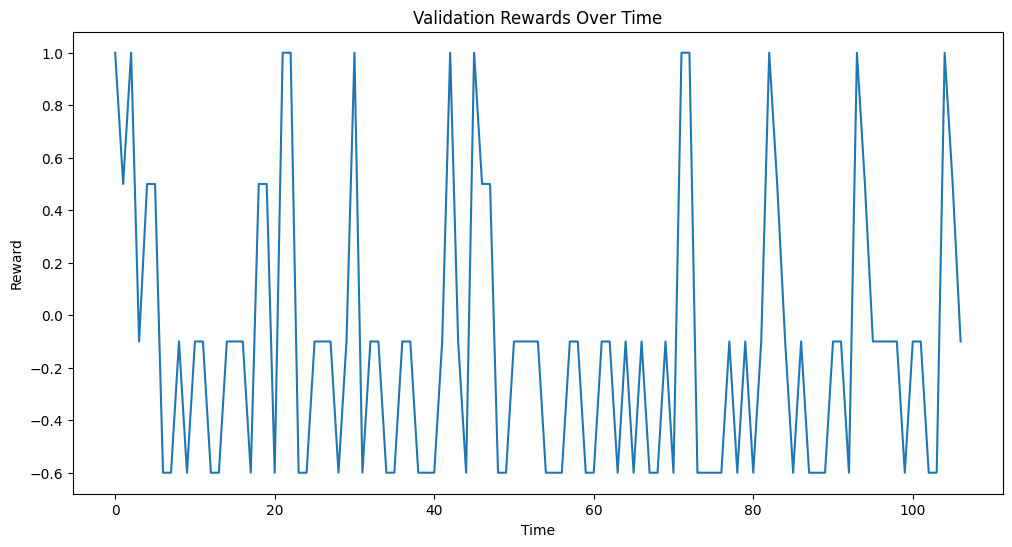

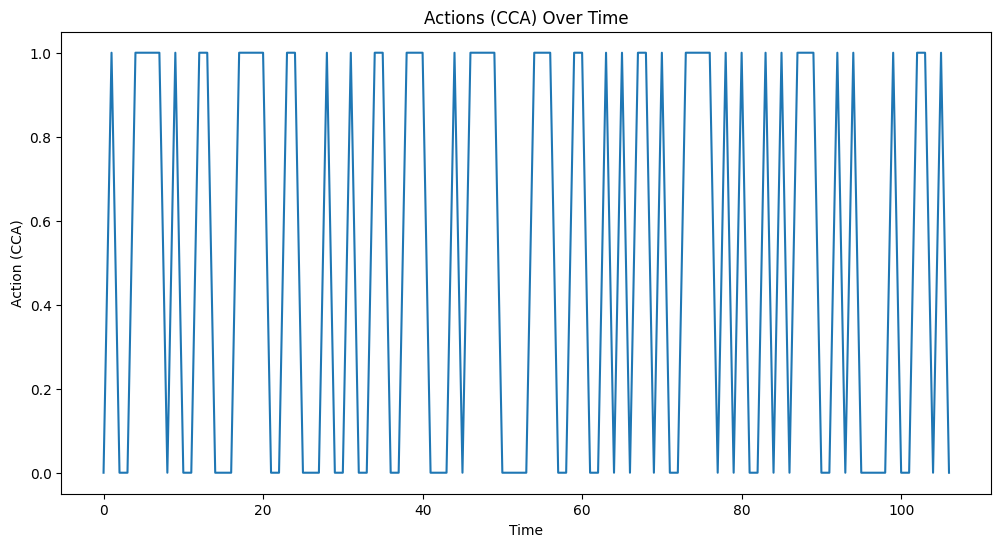

In [18]:
import matplotlib.pyplot as plt

# Validate the model
obs = env.reset()
rewards = []
actions = []

for _ in range(len(test_data)):
    # Use agent.model to predict actions
    action = agent.act(obs) # Use agent's act method to get action
    obs, reward, done, info = env.step(action)
    rewards.append(reward)
    actions.append(action)
    if done:
        break

# Plot rewards
plt.figure(figsize=(12, 6))
plt.plot(rewards)
plt.xlabel('Time')
plt.ylabel('Reward')
plt.title('Validation Rewards Over Time')
plt.savefig('validation_rewards.png')
plt.show()

# Plot actions
plt.figure(figsize=(12, 6))
plt.plot(actions)
plt.xlabel('Time')
plt.ylabel('Action (CCA)')
plt.title('Actions (CCA) Over Time')
plt.savefig('actions.png')
plt.show()

In [ ]:
import gym
from gym import spaces
import numpy as np
import os

class CongestionControlEnv(gym.Env):
    def __init__(self, data, thresholds):
        super(CongestionControlEnv, self).__init__()
        self.data = data
        self.thresholds = thresholds
        self.observation_space = spaces.Box(low=0, high=1, shape=(4,), dtype=np.float32)  # Throughput, Latency, LossRate, SendingRate
        self.action_space = spaces.Discrete(2)  # Binary action: 0 for no switch, 1 for switch
        self.current_step = 0
        self.current_cca = 'BBR'  # Assume starting with BBR

    def reset(self):
        self.current_step = 0
        self.current_cca = 'BBR'  # Reset to starting CCA
        self.state = self.data.iloc[self.current_step][['Throughput', 'Latency', 'LossRate', 'SendingRate']].values
        return self.state

    def step(self, action):
        if action == 1:
            self._switch_cca()

        self.current_step += 1
        done = self.current_step >= len(self.data)
        if not done:
            self.state = self.data.iloc[self.current_step][['Throughput', 'Latency', 'LossRate', 'SendingRate']].values
            reward = self._calculate_reward(action) # Calculate reward before state is potentially set to None
        else:
            self.state = None
            reward = 0 # No reward if episode is done

        return self.state, reward, done, {} # Return the calculated reward

    def _calculate_reward(self, action):
        disparities = np.abs(self.state - self.data.iloc[self.current_step-1][['Throughput', 'Latency', 'LossRate', 'SendingRate']].values)
        reward = 0
        if np.any(disparities > self.thresholds):
            reward += 1  # High disparities reward
        else:
            reward -= 0.1  # Low disparities penalty
        if action == 1:
            reward -= 0.5  # Switching penalty
        return reward

    def _switch_cca(self):
       if self.current_cca == 'BBR':
           self.current_cca = 'CUBIC'
           os.system('sysctl -w net.ipv4.tcp_congestion_control=cubic')
       elif self.current_cca == 'CUBIC':
           self.current_cca = 'PCC'  # Switch to PCC
           os.system('sysctl -w net.ipv4.tcp_congestion_control=pcc') # Assuming PCC is available
       elif self.current_cca == 'PCC':
           self.current_cca = 'BBR'
           os.system('sysctl -w net.ipv4.tcp_congestion_control=bbr')
       print(f"Switched CCA to {self.current_cca}")

In [33]:
# Evaluation loop
test_env = CongestionControlEnv(data=test_data, thresholds=[0.1, 0.1, 0.1, 0.1])
test_total_reward = 0
test_state = test_env.reset()
test_state = np.reshape(test_state, [1, state_shape[0]])
test_done = False
while not test_done:
    test_action = agent.act(test_state)
    test_next_state, test_reward, test_done, _ = test_env.step(test_action)
    if test_next_state is not None:
        test_next_state = np.reshape(test_next_state, [1, state_shape[0]])
        test_total_reward += test_reward
        test_state = test_next_state
    else:
        break
print(f"Total Test Reward: {test_total_reward}")


Total Test Reward: 1.1


In [37]:

import matplotlib.pyplot as plt
import numpy as np

# Plotting the test rewards
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_test_episodes + 1), test_rewards, marker='o')
plt.title('Test Rewards Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.grid(True)
plt.show()

NameError: name 'n_test_episodes' is not defined

<Figure size 1000x600 with 0 Axes>

In [ ]:
# Load the trained model
agent.model = tf.keras.models.load_model("dqn_model.h5")

# Real-time switching loop (pseudo-code, adapt as needed for your specific implementation)
real_time_data = pd.read_csv("/content/client2_bbr_switch_cubic.csv")  # Real-time data loading
real_time_env = CongestionControlEnv(data=real_time_data, thresholds=[0.1, 0.1, 0.1, 0.1])
real_time_state = real_time_env.reset()
real_time_state = np.reshape(real_time_state, [1, state_shape[0]])
real_time_done = False
while not real_time_done:
    real_time_action = agent.act(real_time_state)
    real_time_next_state, _, real_time_done, _ = real_time_env.step(real_time_action)
    if real_time_next_state is not None:
        real_time_next_state = np.reshape(real_time_next_state, [1, state_shape[0]])
        real_time_state = real_time_next_state
    else:
        break


Switched CCA to CUBIC
Switched CCA to PCC
Switched CCA to BBR
Switched CCA to CUBIC
Switched CCA to PCC
Switched CCA to BBR
Switched CCA to CUBIC
Switched CCA to PCC
Switched CCA to BBR
Switched CCA to CUBIC
Switched CCA to PCC
Switched CCA to BBR
Switched CCA to CUBIC
Switched CCA to PCC
Switched CCA to BBR
Switched CCA to CUBIC
Switched CCA to PCC
Switched CCA to BBR
Switched CCA to CUBIC
Switched CCA to PCC
Switched CCA to BBR
Switched CCA to CUBIC
Switched CCA to PCC
Switched CCA to BBR
Switched CCA to CUBIC
Switched CCA to PCC
Switched CCA to BBR
Switched CCA to CUBIC
Switched CCA to PCC


<ipython-input-66-15545ec5fb7e>:40: RuntimeWarning: invalid value encountered in greater
  if np.any(disparities > self.thresholds):
<ipython-input-66-15545ec5fb7e>:40: RuntimeWarning: invalid value encountered in greater
  if np.any(disparities > self.thresholds):
<ipython-input-66-15545ec5fb7e>:40: RuntimeWarning: invalid value encountered in greater
  if np.any(disparities > self.thresholds):
<ipython-input-66-15545ec5fb7e>:40: RuntimeWarning: invalid value encountered in greater
  if np.any(disparities > self.thresholds):
<ipython-input-66-15545ec5fb7e>:40: RuntimeWarning: invalid value encountered in greater
  if np.any(disparities > self.thresholds):


Switched CCA to BBR
Switched CCA to CUBIC
Switched CCA to PCC
Switched CCA to BBR
Switched CCA to CUBIC
Switched CCA to PCC
Switched CCA to BBR
Switched CCA to CUBIC
Switched CCA to PCC
Switched CCA to BBR
Switched CCA to CUBIC
Switched CCA to PCC
Switched CCA to BBR
Switched CCA to CUBIC
Switched CCA to PCC
Switched CCA to BBR
Switched CCA to CUBIC
Switched CCA to PCC
Switched CCA to BBR
Switched CCA to CUBIC
Switched CCA to PCC
Switched CCA to BBR
Switched CCA to CUBIC
Switched CCA to PCC
Switched CCA to BBR
Switched CCA to CUBIC
Switched CCA to PCC


<ipython-input-66-15545ec5fb7e>:40: RuntimeWarning: invalid value encountered in greater
  if np.any(disparities > self.thresholds):
<ipython-input-66-15545ec5fb7e>:40: RuntimeWarning: invalid value encountered in greater
  if np.any(disparities > self.thresholds):
<ipython-input-66-15545ec5fb7e>:40: RuntimeWarning: invalid value encountered in greater
  if np.any(disparities > self.thresholds):
<ipython-input-66-15545ec5fb7e>:40: RuntimeWarning: invalid value encountered in greater
  if np.any(disparities > self.thresholds):
<ipython-input-66-15545ec5fb7e>:40: RuntimeWarning: invalid value encountered in greater
  if np.any(disparities > self.thresholds):
